# FL Model
## Decision Tree, Random Forest, and Partial Dependence Plots

* on the linux box, using raster env 


In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats

In [2]:
ds = xr.open_dataset('/home/lumbraca/raster/data/fl_model_cleandata_create_netcdf.nc')

In [3]:
# flatten everything to save time later
# canopy parameters
chm_snowoff_flat=ds.chm_snowoff.values.flatten()
chmws_flat=ds.chmws.values.flatten()
chmas_flat=ds.chmas.values.flatten()
dce_flat=ds.dce.values.flatten()
dce_reclass_flat=ds.dce_reclass.values.flatten()

# else 
slope_flat=ds.slope.values.flatten()
aspect_flat=ds.aspect.values.flatten()
dah_flat=ds.dah.values.flatten()
dah_reclass_flat=ds.dah_reclass.values.flatten()

snowdepth_flat=ds.snowdepth.values.flatten()
dem_flat=ds.dem.values.flatten()
tpi_flat=ds.tpi.values.flatten()

# I did not make these in the netcdf script 
# dce_dahpos_reclass_flat=ds.dce_dahpos_reclass.values.flatten()
# dce_dahneg_reclass_flat=ds.dce_dahneg_reclass.values.flatten()

# Sample Dataset First 

### Import all the sklearn things

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import pydotplus 
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

#### We want to use a random forest generator to determine what best predictors for snow depth 
* ds.dem
* ds.dah
* ds.dce

In [16]:
# with regular dah and dce
ds_snowdepth = ds.snowdepth.values.flatten()
ds_dem = ds.dem.values.flatten()
ds_dah = ds.dah.values.flatten() # when we convert to an int, we are making all DAH 0? need to fix this for random forest 

ds_tpi = ds.tpi.values.flatten() 

ds_dah = ds_dah * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis
ds_dah = ds_tpi * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis

ds_dce = ds.dce.values.flatten()

# # with reclass dah and dce 
# ds_snowdepth = ds.snowdepth.values.flatten()
# ds_dem = ds.dem.values.flatten() 
# ds_dah = ds.dah_reclass.values.flatten()
# ds_dce = ds.dce_reclass.values.flatten()

If you want to subsample those variables, then run this gridcell below

In [17]:
# and if you want to subsample those values, then run this cell

num = 100 # number to sample (step) at... every other.. every 5, 10 etc.

ds_snowdepth = ds_snowdepth[::num] #start:stop:step
ds_dem = ds_dem[::num] 
ds_dce = ds_dce[::num] 
ds_dah = ds_dah[::num] 
ds_tpi = ds_tpi[::num] 

# then, create df 
df = pd.DataFrame({'snowdepth': ds_snowdepth,
                   'dem': ds_dem, 
                   'dah': ds_dah, 
                   'tpi': ds_tpi,
                   'dce': ds_dce})

# random forest cannot have any na values
# df.snowdepth.dropna(inplace=True)
df.dropna(how='any', inplace=True) # it has to be everything 

df

,snowdepth,dem,dah,tpi,dce
3389,2.841278,1924.200439,206.668640,2.066686,-1.828800
3462,3.680222,1925.926758,87.921509,0.879215,-2.586314
3535,4.143822,1927.426758,-5.940552,-0.059406,-4.572000
3608,4.338191,1928.974121,-50.083496,-0.500835,-2.044661
3681,4.271814,1930.759399,-37.989380,-0.379894,-2.044661
...,...,...,...,...,...
539277,3.614142,1658.277344,27.859863,0.278599,0.914400
539350,3.570982,1658.215942,18.850037,0.188500,-0.914400
539423,3.345656,1658.037354,-10.550720,-0.105507,0.914400
539496,3.339703,1657.810547,-54.091000,-0.540910,0.914400


## Plot the data to see how the subsampling worked

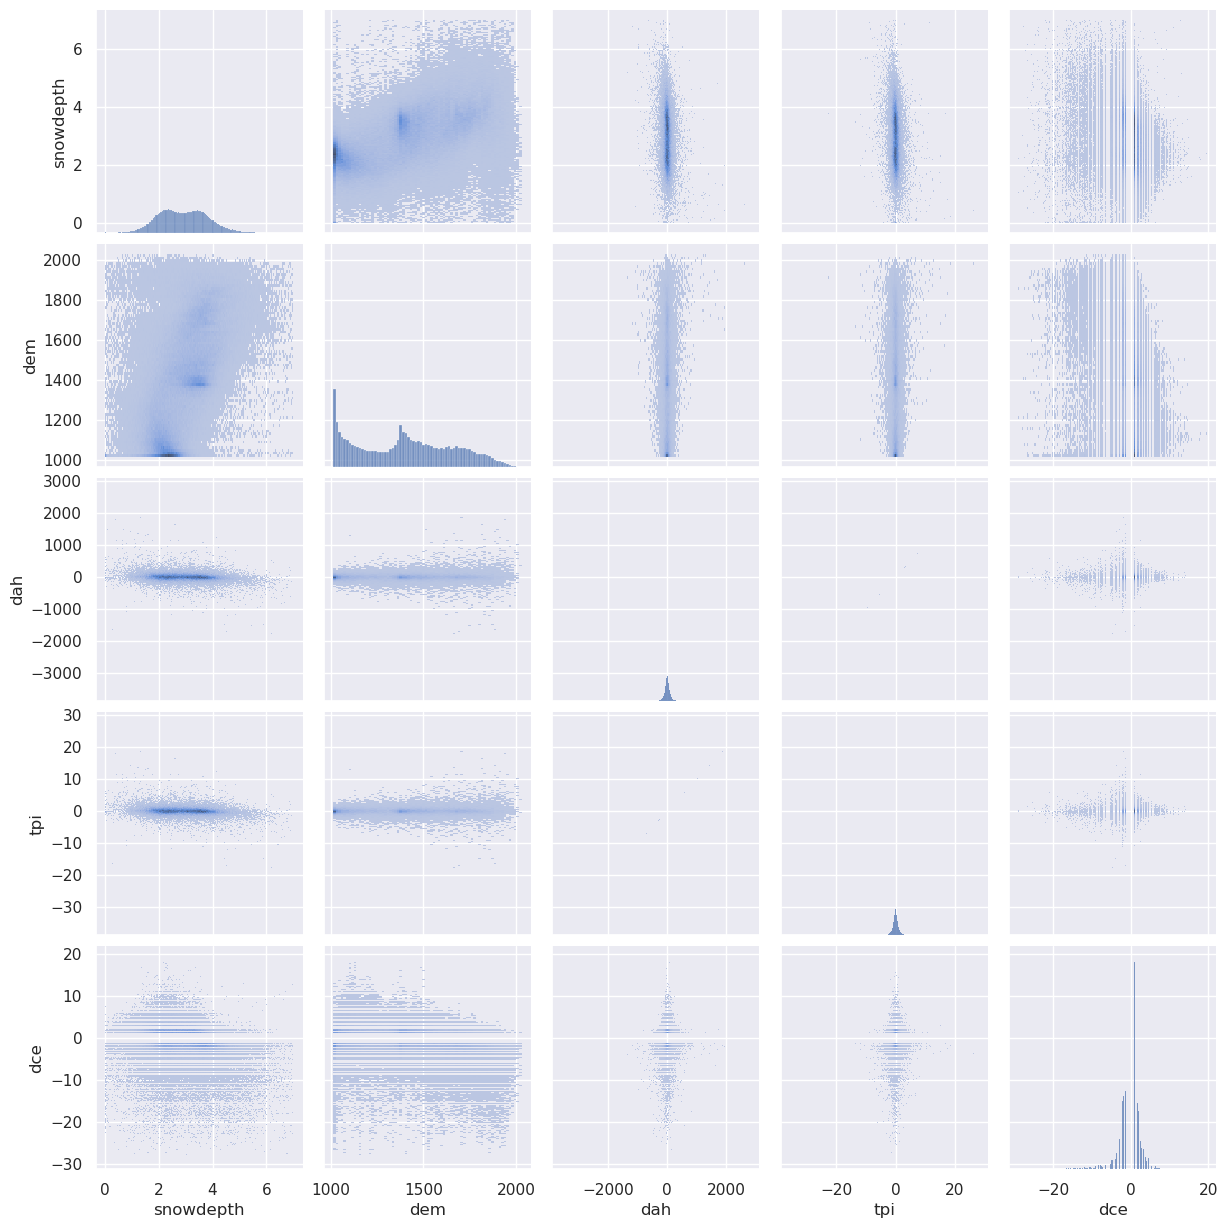

In [18]:
sns.pairplot(df, kind='hist') # kind="hist"

## Back to preparing the dataset for random forest

In [19]:
df_int = df.copy(deep=True)
df_int['snowdepth'] = df_int['snowdepth'].astype(int)
df_int['dem'] = df_int['dem'].astype(int)
df_int['dah'] = df_int['dah'].astype(int)
df_int['dce'] = df_int['dce'].astype(int)
df_int['tpi'] = df_int['tpi'].astype(int)

df_int.head()

,snowdepth,dem,dah,tpi,dce
3389,2,1924,206,2,-1
3462,3,1925,87,0,-2
3535,4,1927,-5,0,-4
3608,4,1928,-50,0,-2
3681,4,1930,-37,0,-2


In [20]:
# if we need snowdepth and other variables is different dataframes
# df1 = pd.DataFrame({'snowdepth': ds_snowdepth})

# df2 = pd.DataFrame({'dem': ds_dem, 
#                    'dah': ds_dah, 
#                    'dce': ds_dce})

In [21]:
# create the x, variables, columns
X = df_int.drop(columns=['snowdepth'])
X.head()

,dem,dah,tpi,dce
3389,1924,206,2,-1
3462,1925,87,0,-2
3535,1927,-5,0,-4
3608,1928,-50,0,-2
3681,1930,-37,0,-2


In [22]:
# create the y, predictor, column
y = df_int.snowdepth
y.head()

3389    2
3462    3
3535    4
3608    4
3681    4
Name: snowdepth, dtype: int64

In [23]:
# x.describe()

X.isnull().values.any()
y.isnull().values.any()

False

## 1. Decision Tree Classifier 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# test_size : taking 20% of the dataset to make the decision 
# then, decision tree goes through this again, but only taking 20% each time 
# random_state as an int, to decide how to recreate results 

In [25]:
# check the size of train dataset, should be 20% (or test_size) based on full test 
len(X_train) 
len(X_test)

54005

In [28]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=4)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
print('Accuracy on train data is %.2f' % (accuracy_score(y_train, y_pred_train)))

y_pred_test = clf.predict(X_test)
print('Accuracy on test data is %.2f' % (accuracy_score(y_test, y_pred_test)))

Accuracy on train data is 0.52
Accuracy on test data is 0.52


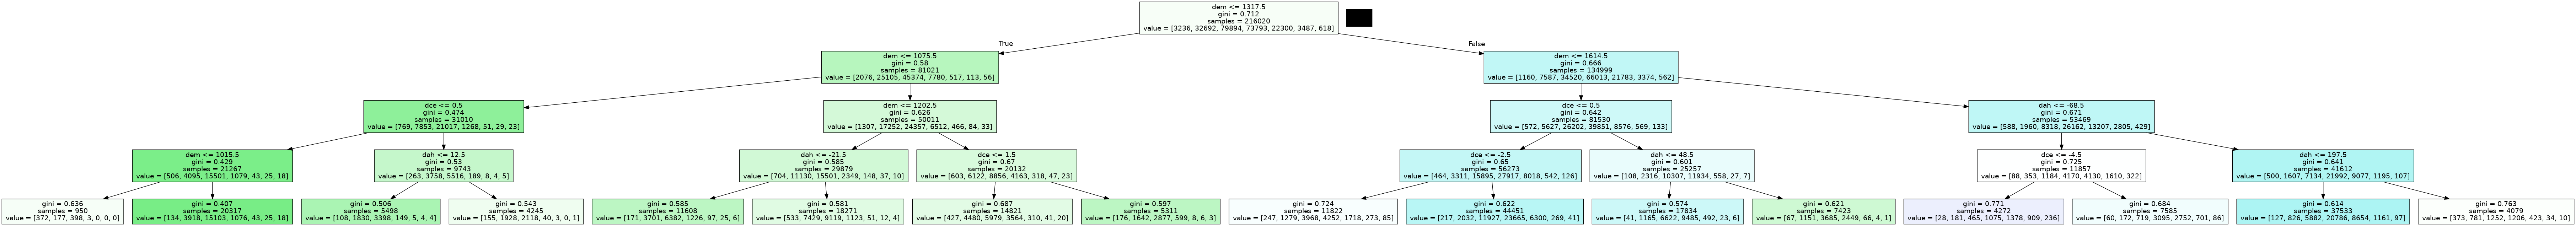

In [29]:
dot_data = tree.export_graphviz(clf, feature_names=X.columns, filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

In [27]:
# sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,cmap='Blues')

## 2. Emsemble Random Forest Classifier 

In [19]:
# n_estimators: the number of times you want to run the decision trees 
# 'n_estimators': [100,250,500]
# 'max_depth':[3,4]
# not sure what "cv" is, but seems to give a warning. needs to be = to number of variables predicting

parameters = {'n_estimators': [10], 'max_depth':[4]}
clf = GridSearchCV(ensemble.RandomForestClassifier(), parameters) #cv=3

clf.fit(X=X_train,y=y_train.values.ravel())
tree_model = clf.best_estimator_

y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)
print('Accuracy on training data is %.2f' % (accuracy_score(y_train, y_pred_train)))
print('Accuracy on test data is %.2f' % (accuracy_score(y_test, y_pred_test)))
print(clf.best_params_)

Accuracy on training data is 0.59
Accuracy on test data is 0.59
{'max_depth': 4, 'n_estimators': 10}


In [25]:
# clf.feature_importances_ #importance of each variable 
clf.feature_names_in_


array(['dem', 'dah', 'tpi', 'dce'], dtype=object)

In [27]:
estimator = tree_model.estimators_[3]
estimator

DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=715570023)

In [28]:
tree.export_graphviz(estimator, out_file='ensemble_tree.dot', 
                feature_names = X.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree.dot', '-o', 'ensemble_tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.69674 to fit


In [16]:
# code taken from Hannah's notebook... but it's not working. something internal sklearn
# dot_data = tree.export_graphviz(tree_model, feature_names=X.columns, filled=True, out_file=None) 
# graph = pydotplus.graph_from_dot_data(dot_data) 
# Image(graph.create_png())

## 3. Partial Dependence Plots

https://scikit-learn.org/stable/modules/partial_dependence.html

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

The sklearn.inspection module provides a convenience function from_estimator to create one-way and two-way partial dependence plots. 

In the below example we show how to create a grid of partial dependence plots: 
* two one-way PDPs for the features 0
* 1 and a two-way PDP between the two features:

In [ ]:
# maybe these plots need help... size is super annoying. need to fix. 
sns.set_theme()
plt.rcParams['figure.figsize'] = [12,6] #overriding size

In [30]:
df

,snowdepth,dem,dah,tpi,dce
3389,2.841278,1924.200439,206.668640,2.066686,-1.828800
3462,3.680222,1925.926758,87.921509,0.879215,-2.586314
3535,4.143822,1927.426758,-5.940552,-0.059406,-4.572000
3608,4.338191,1928.974121,-50.083496,-0.500835,-2.044661
3681,4.271814,1930.759399,-37.989380,-0.379894,-2.044661
...,...,...,...,...,...
539277,3.614142,1658.277344,27.859863,0.278599,0.914400
539350,3.570982,1658.215942,18.850037,0.188500,-0.914400
539423,3.345656,1658.037354,-10.550720,-0.105507,0.914400
539496,3.339703,1657.810547,-54.091000,-0.540910,0.914400


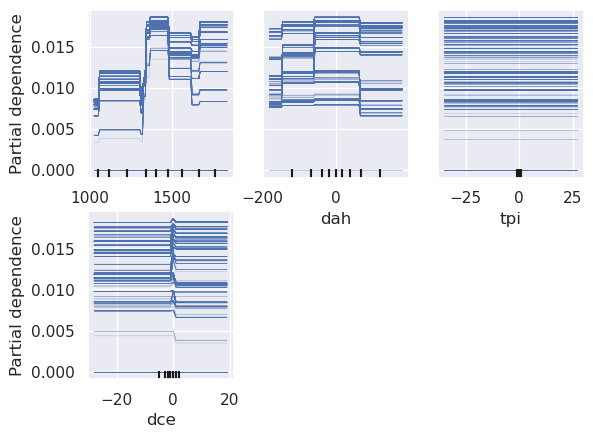

In [31]:
clf = GradientBoostingClassifier(n_estimators=5, learning_rate=1.0, max_depth=1, random_state=0).fit(X, y) # small amount of n-estimators for now

# features = [0, 1, (0, 1)] # this means, dem, then dah, then dem vs dah (features in X)
features = [0, 1, 2, 3]  # this is all 4 features 

PartialDependenceDisplay.from_estimator(clf, X, features, kind='individual', target=0) # The same parameter target is used to specify the target in multi-output regression settings.

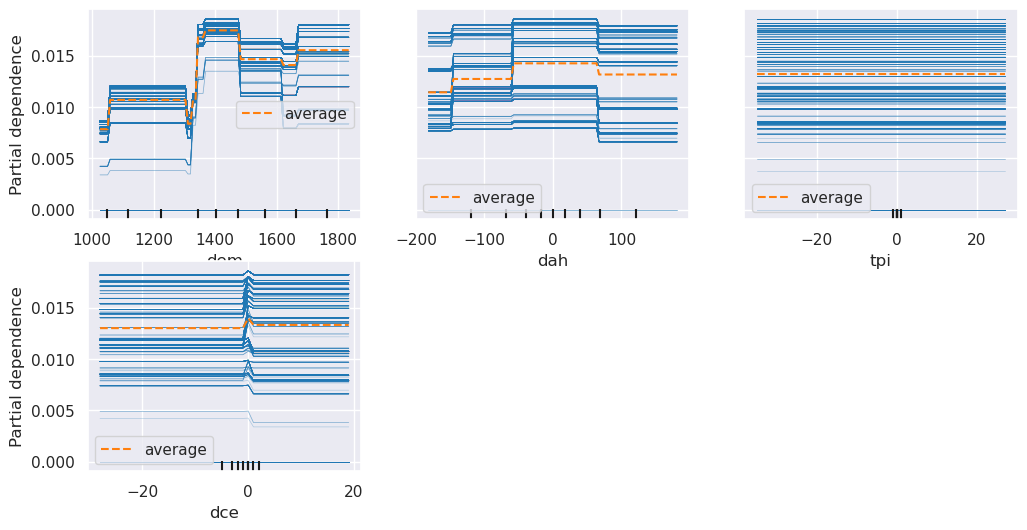

In [33]:
PartialDependenceDisplay.from_estimator(clf, X, features, kind='both', target=0) # The same parameter target is used to specify the target in multi-output regression settings.

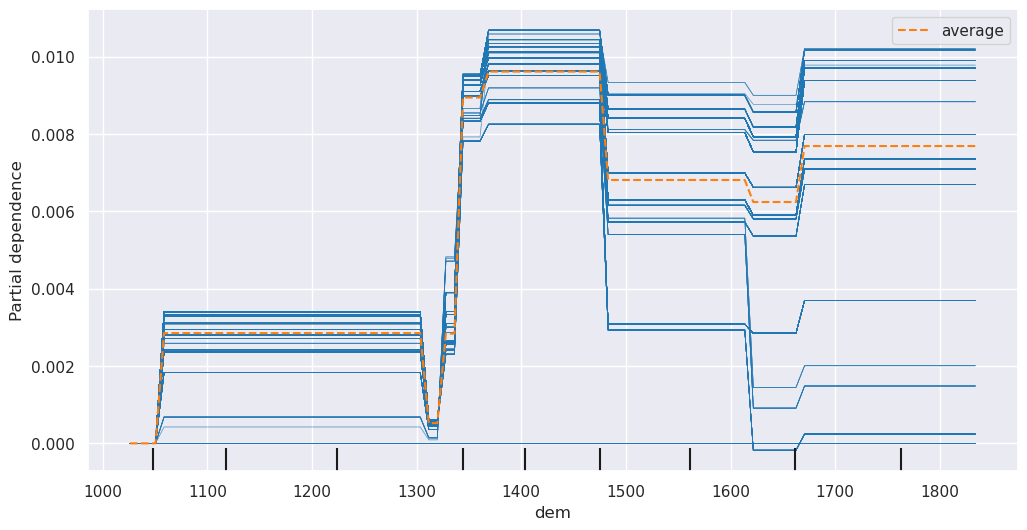

In [34]:
# just looking at 1 feature at a time 
plt.rcParams['figure.figsize'] = [12,6] #overriding size
features = [0]
PartialDependenceDisplay.from_estimator(clf, X, features, target=0, kind='both', centered=True)

(985.0, 1880.0)

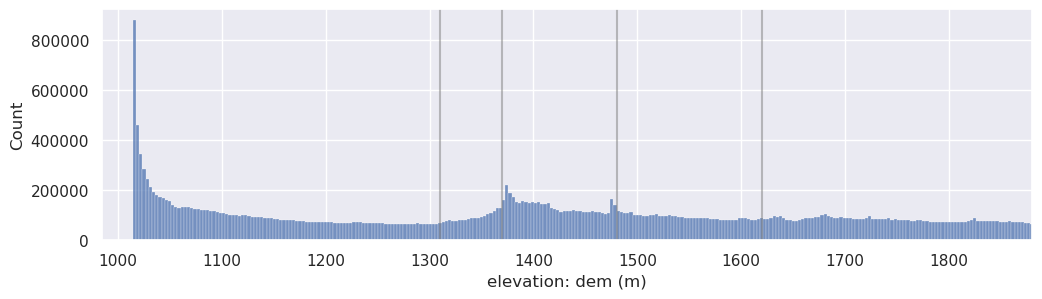

In [58]:
plt.rcParams['figure.figsize'] = [12,3] #overriding size
sns.histplot(data=dem_flat)
plt.axvline(x=1310, color='grey', alpha=.5)
plt.axvline(x=1370, color='grey', alpha=.5)
plt.axvline(x=1480, color='grey', alpha=.5)
plt.axvline(x=1620, color='grey', alpha=.5)

# plt.title('Fish Lake')
plt.xlabel('elevation: dem (m)')
plt.xlim([985, 1880])

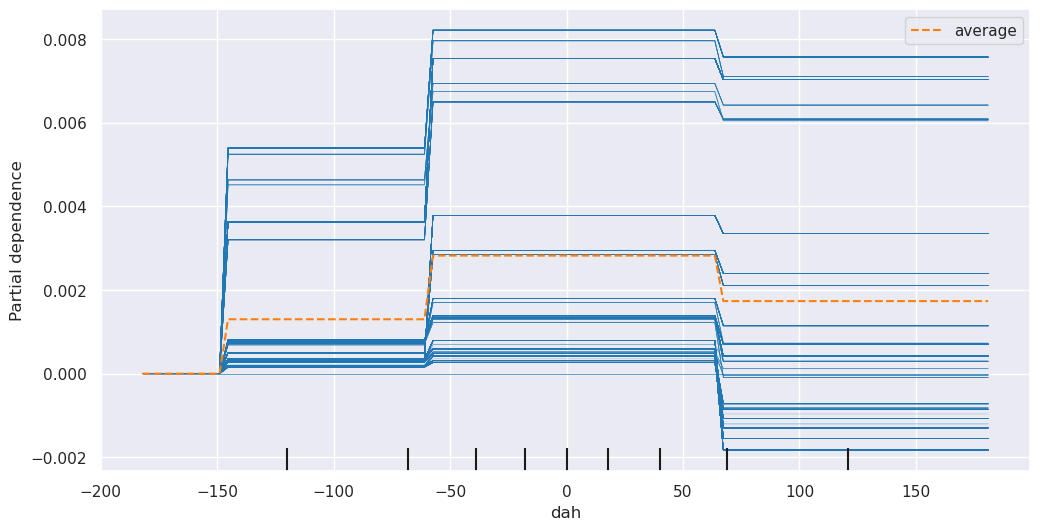

In [37]:
# just looking at 1 feature at a time 
plt.rcParams['figure.figsize'] = [12,6] #overriding size
features = [1]
PartialDependenceDisplay.from_estimator(clf, X, features, target=0, kind='both', centered=True)

(-200.0, 200.0)

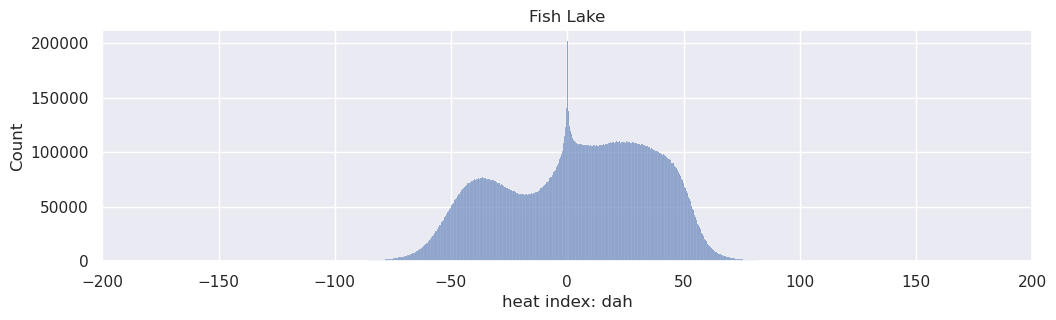

In [43]:
plt.rcParams['figure.figsize'] = [12,3] #overriding size
sns.histplot(data=(dah_flat)*100)
plt.title('Fish Lake')
plt.xlabel('heat index: dah')
plt.xlim([-200, 200])

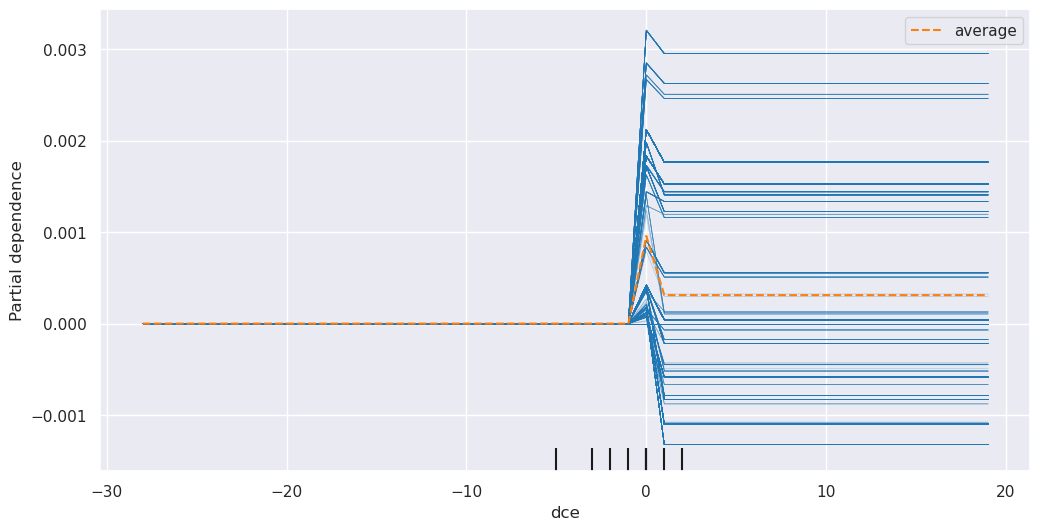

In [46]:
# just looking at 1 feature at a time 
plt.rcParams['figure.figsize'] = [12,6] #overriding size
features = [3]
PartialDependenceDisplay.from_estimator(clf, X, features, target=0, kind='both', centered=True)

Text(0.5, 0, 'distance to canopy edge')

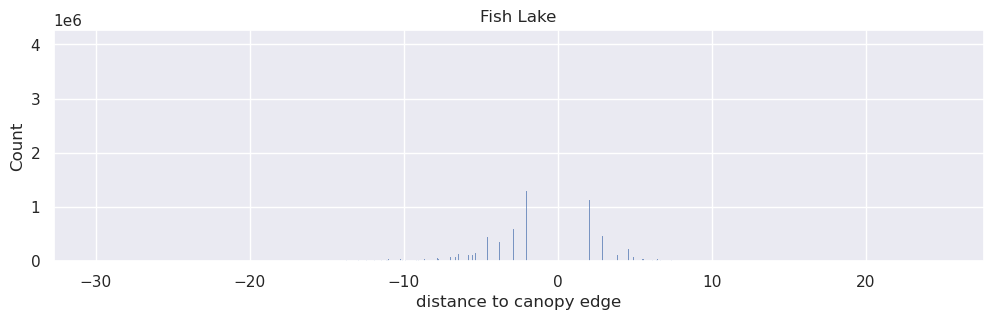

In [47]:
plt.rcParams['figure.figsize'] = [12,3] #overriding size
sns.histplot(data=dce_flat)
plt.title('Fish Lake')
plt.xlabel('distance to canopy edge')
# plt.xlim([-200, 200])

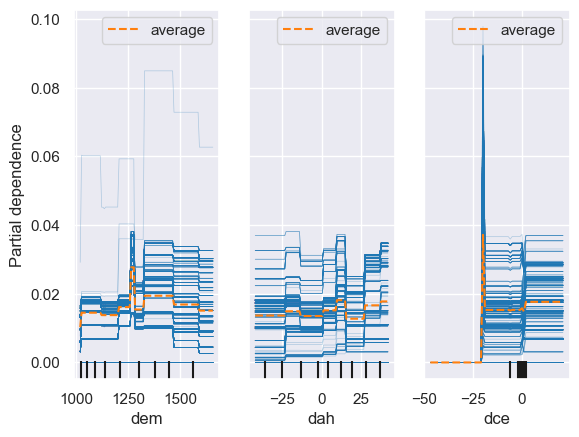

In [ ]:
plt.rcParams['figure.figsize'] = [20,5] #overriding size
features = [0, 1, 2, 3] 
PartialDependenceDisplay.from_estimator(clf, X, features, target=0, kind='both')

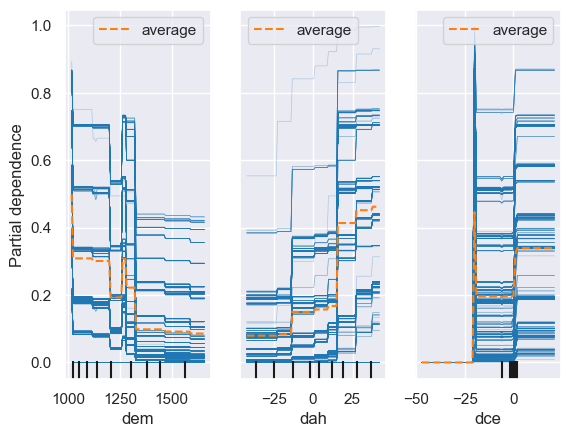

In [ ]:
plt.rcParams['figure.figsize'] = [20,5] #overriding size
features = [0, 1, 2, 3] 
PartialDependenceDisplay.from_estimator(clf, X, features, target=1, kind='both') # changing the target feature? 

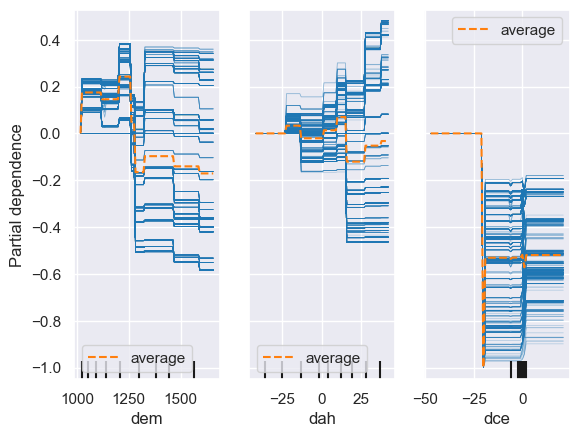

In [ ]:
features = [0, 1, 2] 
PartialDependenceDisplay.from_estimator(clf, X, features, target=2, kind='both', centered=True) # changing the target feature? 

In [44]:
# features = [1, 2, (1,2)] 
# PartialDependenceDisplay.from_estimator(clf, X, features, target=2, kind=['both', 'both', 'average'], centered=True)

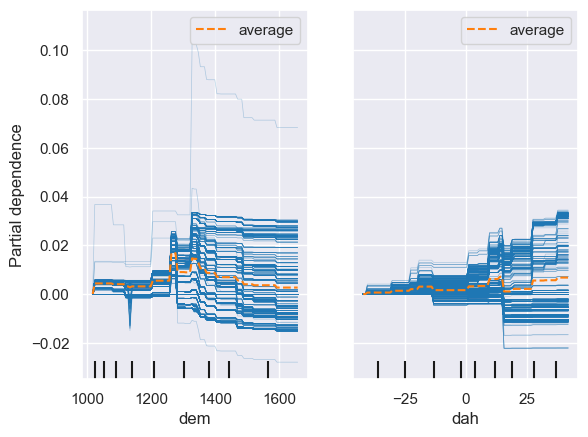

In [ ]:
features = [0, 1] 
PartialDependenceDisplay.from_estimator(clf, X, features, target=0, kind='both', centered=True)

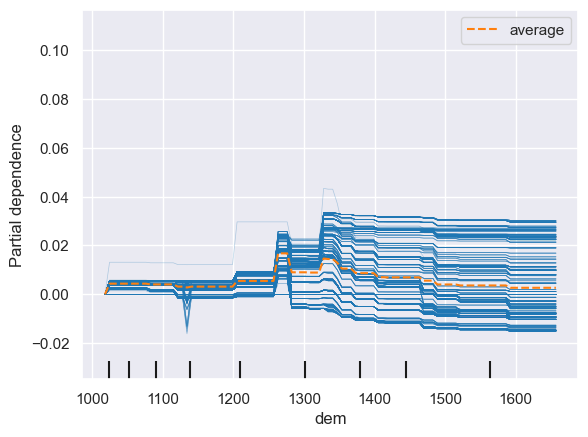

In [90]:
features = [0] 
PartialDependenceDisplay.from_estimator(clf, X, features, target=0, kind='both', centered=True)